<a href="https://colab.research.google.com/github/reeda23/Deep-Learning-With-Pytorch/blob/main/13_Convolutional_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Network


# Importing Libraries

In [31]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np


In [32]:
# device configuration
# check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper parameters

In [33]:
num_epochs = 5
batch_size = 4
learning_rate = 0.001


# Dataset

**Normalization**

In [34]:
#dataset has PILImage images of range [0, 1]
#to normalize them between range [-1,1] we transform them to tensors
transform = transforms.Compose(
                        [transforms.ToTensor(),
                         transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])

**DataLoader**

In [35]:
# CIFAR10: 60000 32x32 color images in 10 classes, with 6000 images per class

train_dataset = torchvision.datasets.CIFAR10(root = './data',
                                             train = True,
                                             download=True,
                                             transform= transform)

test_dataset = torchvision.datasets.CIFAR10(root = './data',
                                             train = False,
                                             download=True,
                                             transform= transform)

train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, 
                                           batch_size=batch_size,
                                           shuffle=False)



Files already downloaded and verified
Files already downloaded and verified


**Classes**

In [36]:
classes = ('plane','car','bird','cat','deer','dog','frog','horse','ship','truck')

**Show Image**

In [37]:
# def imshow(img):
#     img = img/ 2+ 0.5  #unnormalize
#     npimg = img.numpy()
#     plt.imshow(np.transpose(npimg, (1,2,0)))
#     plt.show()

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))

**Random training images**

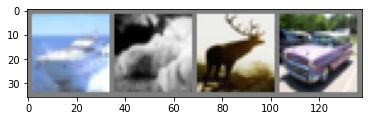

In [38]:
#get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()


#show images
imshow(torchvision.utils.make_grid(images))


# CNN Model

In [39]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3,6,5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6,16,5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)

    def forward(self, x):
        #--> n,3,32,32
        x = self.pool(F.relu(self.conv1(x))) #->n, 6, 14, 14
        x = self.pool(F.relu(self.conv2(x))) #->n, 16, 5, 5
        x = x.view(-1, 16 * 5 * 5)           #->n, 400
        x = F.relu(self.fc1(x))              #->n, 120
        x = F.relu(self.fc2(x))              #->n, 84
        x = self.fc3(x)                      #->n, 10
        return x

model = ConvNet().to(device)

# Loss and Optimizer

In [40]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

# Training

In [41]:
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        #original shape: [4, 3, 32, 32] = 4, 3, 1024
        #input_layer = 3 input channels, 6 output channels, 5 kernal size
        images = images.to(device)
        labels = labels.to(device)

        #Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        #Backward and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 2000 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
        

print("Finshed Training")
PATH = './cnn.pth'
torch.save(model.state_dict(), PATH)

Epoch [1/5], Step [2000/12500], Loss: 2.2996
Epoch [1/5], Step [4000/12500], Loss: 2.2853
Epoch [1/5], Step [6000/12500], Loss: 2.2959
Epoch [1/5], Step [8000/12500], Loss: 2.2778
Epoch [1/5], Step [10000/12500], Loss: 2.2772
Epoch [1/5], Step [12000/12500], Loss: 1.7155
Epoch [2/5], Step [2000/12500], Loss: 1.7023
Epoch [2/5], Step [4000/12500], Loss: 1.5244
Epoch [2/5], Step [6000/12500], Loss: 1.9770
Epoch [2/5], Step [8000/12500], Loss: 1.6927
Epoch [2/5], Step [10000/12500], Loss: 1.7588
Epoch [2/5], Step [12000/12500], Loss: 1.4496
Epoch [3/5], Step [2000/12500], Loss: 1.7438
Epoch [3/5], Step [4000/12500], Loss: 1.7716
Epoch [3/5], Step [6000/12500], Loss: 1.9159
Epoch [3/5], Step [8000/12500], Loss: 1.5507
Epoch [3/5], Step [10000/12500], Loss: 1.0501
Epoch [3/5], Step [12000/12500], Loss: 1.6828
Epoch [4/5], Step [2000/12500], Loss: 0.6129
Epoch [4/5], Step [4000/12500], Loss: 1.1960
Epoch [4/5], Step [6000/12500], Loss: 2.3213
Epoch [4/5], Step [8000/12500], Loss: 2.0193
Epoc

# Testing

In [42]:
with torch.no_grad():
    n_correct = 0 
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]

    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)

        #max returns (value, index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

        for  i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] +=1

**Accuracy**

In [43]:
acc = 100.0 * n_correct  / n_samples
print(f'Accuracy of the network: {acc} %')

for i in range(10):
    acc = 100.0 * n_class_correct[i] / n_class_samples[i]
    print(f'Accuracy of {classes[i]}: {acc} %')

Accuracy of the network: 48.88 %
Accuracy of plane: 46.7 %
Accuracy of car: 71.9 %
Accuracy of bird: 23.9 %
Accuracy of cat: 32.0 %
Accuracy of deer: 34.6 %
Accuracy of dog: 45.8 %
Accuracy of frog: 67.3 %
Accuracy of horse: 50.3 %
Accuracy of ship: 53.5 %
Accuracy of truck: 62.8 %


# Visualize Sample Test Result

In [44]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


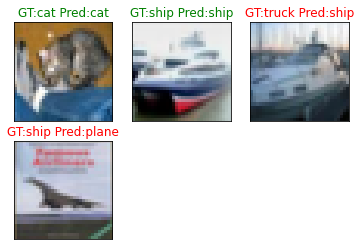

In [50]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if torch.cuda.is_available():
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(preds_tensor.cpu().numpy())
if torch.cuda.is_available():
    images = images.cpu()
# plot the images in the batch, along with predicted and true labels

for idx in range(batch_size):
    ax = plt.subplot(2, 3, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title("GT:{} Pred:{}".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))